In [1]:
!pip install gmplot
!pip install pyproj
!pip install mplstereonet
!pip install shapely
!pip install geopandas

    100% |████████████████████████████████| 122kB 2.5MB/s ta 0:00:01
  Running setup.py bdist_wheel for gmplot ... done
  Stored in directory: /home/nbuser/.cache/pip/wheels/81/6a/76/4dd6a7cc310ba765894159ee84871e8cd55221d82ef14b81a1
Successfully built gmplot
grpcio 1.11.0 has requirement protobuf>=3.5.0.post1, but you'll have protobuf 3.4.1 which is incompatible.
    100% |████████████████████████████████| 4.4MB 1.3MB/s eta 0:00:01
  Running setup.py bdist_wheel for pyproj ... done
  Stored in directory: /home/nbuser/.cache/pip/wheels/89/77/ec/a537585d1022dafde0317dd19d33c4a30d4ee61e19f25ebd8e
Successfully built pyproj
grpcio 1.11.0 has requirement protobuf>=3.5.0.post1, but you'll have protobuf 3.4.1 which is incompatible.
    100% |████████████████████████████████| 1.1MB 4.1MB/s eta 0:00:01
  Running setup.py bdist_wheel for mplstereonet ... done
  Stored in directory: /home/nbuser/.cache/pip/wheels/bb/72/2a/fe407620c3df459ab82f4cf9891442932e1bac653d05a267af
Successfully built mplst

In [2]:
# IMPORTANTE ATTENZIONE OCCORRE CONVERTIRE IL FILE DIINGRESSO DEI PUNTI
# IN COORDINATE PIANE METRICHE 

import pandas as pd
import numpy as np
import scipy.linalg
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import datetime
from shapely.geometry import Point
from geopandas import GeoDataFrame


import mplstereonet
#from mpl_toolkits.basemap import pyproj
#from mpl_toolkits.basemap import Basemap
from pyproj import Proj, transform
###################################plotly_block###################################################### 
# Import plotly package online####################
import plotly
plotly.tools.set_credentials_file(username='davide.schenone', api_key='WBSgVI0FXgSIRecK2cHU')
import plotly.graph_objs as go
# Check ploltly version
plotly.__version__

#plotly offline###############
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.graph_objs import *
init_notebook_mode(connected=True) #attivando o disattivando questa riga si ottiene un plot 
                                   #contestuale rispettivamente in notebook oppure su un html

# To communicate with Plotly's server, sign in with credentials file
import plotly.plotly as py
################################################################################################

from pandas import ExcelWriter
from pandas import ExcelFile
# Create data with x and y random over [-2, 2], and z a Gaussian function of x and y.
#np.random.seed(12345)
#x = 2 * (np.random.random(500) - 0.5)
#y = 2 * (np.random.random(500) - 0.5)

#def f(x, y):
 #   return np.exp(-(x + y ** 2))

#z = f(x, y)

#imposto i dati
#importa il file originale
#df = pd.read_csv('Saorge_Taggia_erh_erz_prof.csv', sep='\t', names=['y', 'x','z','a','b'])

#importa il file convertito con convergo
df = pd.read_excel('terremoti_santo.xlsx', sheet_name='Foglio1')


df['z'] = df['Prof corr']  #creo il campo z profondità con valori negativi


df['Data'] = df['Data'].astype(str).str.zfill(6) #riempie la mancanza dello zero nei primi valori
df['Data'] =  pd.to_datetime(df['Data'],  format='%y%m%d')
#df['Ora'] =  pd.to_time(df['Ora'],  format='%H%M')
#creo una colonna con  la differenza in giorni tra la data e una posta abbastanza indietro nel passato
df['Deltatime'] = df['Data'] - datetime.date(1989,1,1)
df['Deltatime'] = df['Deltatime'].astype(datetime.timedelta).map(lambda x: np.nan if pd.isnull(x) else x.days)

#converto le coordinate wgs 84 in UTM epsg 3003 Gauss-Boaga 
x1 = np.array(df['Longit.'])
y1 = np.array(df['Latitud.'])


inProj = Proj(init='epsg:4326')
outProj = Proj(init='epsg:3003')
x2,y2 = transform(inProj,outProj, x1, y1)

df['x'] = x2
df['y'] = y2

#con questo posso fare dei cluster temporali
#IMPOSTO I FILTRI

#df_filter = df.query('Erh<1 and Erz<4') #imposto i parametri di filtro sugli errori orizzontali e verticali


#df_filter = df.query('<Deltatime<') #imposto il filtro sulla data

#imposto i pesi per il calcolo del piano da utilizzare in caso di regressione lineare pesata

df['weight_calc'] = df['Nf']/24 - 0.25
def weight(df):
    if df['Nf'] <=6 :
        return 0
    
    elif  df['Nf'] > 6 and df['Nf']  < 30   :
        return df['weight_calc']
            
    elif  df['Nf'] >= 30 :
        return 1

df['weights'] =  df.apply(weight, axis=1) 
 

    
df_filter = df




/home/nbuser/anaconda3_501/lib/python3.6/site-packages/matplotlib/font_manager.py:281: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


In [3]:

def piano(A,B,C_,D):

    #calcolo E
    E=np.sqrt(A**2 + B**2 + 1)

    #calcolo i coseni
    cos_a = A/E

    cos_b = B/E

    cos_cp = C_/E  #gamma_p


    cos_c = np.cos((np.pi/2) + np.arccos(C_/E))   #controllare se è corretto 

    #calcolo la direzione teta del vettore, il coseni direttori danno la direzione del vettore occorrre aggiungere 90°
    teta_primo = np.arctan(cos_a/cos_b)   #espresso in radianti
    teta_deg = (teta_primo*180)/np.pi 

    #calcolo della direzione della massima pendenza sul piano
    #dip_direction = teta_deg 

    #calcolo l'immersione dip angolo tra la verticale e il piano
    dip_vert = np.arcsin(-1*cos_c)
    dip_deg = (dip_vert*180)/np.pi

    #calcolo l'immersione dip
    dip = dip_deg
    #occorre orientare correttamente il dip_direction
    #cond_1 = dip_direction = teta_deg
    #cond_2 = dip_direction = teta_deg + 180
    #cond_3 = dip_direction =  teta_deg + 360

    #def orientation(cos_a,cos_b):

    if cos_a > 0 and cos_b > 0:                
        dip_direction = teta_deg
        if cos_cp <0:
            dip_direction =  dip_direction + 180

    if  cos_a > 0 and cos_b < 0:
        dip_direction = teta_deg + 180
        if cos_cp <0:
            dip_direction =  dip_direction + 180


    if  cos_a < 0 and cos_b < 0:
        dip_direction = teta_deg + 180
        if cos_cp <0:
            dip_direction =  dip_direction - 180


    if  cos_a < 0 and cos_b > 0:
        dip_direction =  teta_deg + 360
        if cos_cp <0:
            dip_direction =  dip_direction - 180








    #creo l'array per il plotaggio su stereogramma
    plot_dip_direction = 0
    plot_dip = 0
    plot_dip_direction = np.append(plot_dip_direction, dip_direction)
    plot_dip = np.append(plot_dip, dip)
    print("dip_direction= %f ; dip= %f" % (dip_direction, dip))
    print(cos_a, cos_b)
    print('##################################################')
    print(teta_deg)
    output = "teta= %f ; dip= %f" % (dip_direction, dip)
    file = open("giacitura_cluster_xx_plane.txt","w")
    file.write(output)
    file.close()

    daframe_cluster_xx = pd.DataFrame.to_csv(df_cluster_2)
    file = open("daframe_cluster_xx_plane.csv","w")
    file.write(daframe_cluster_xx)
    file.close()

    #salva i risultati su di un file shape
    geometry = [Point(xy) for xy in zip(df_cluster_2.x , df_cluster_2.y)]
    df_shape = df_cluster_2.drop(['x', 'y','Ora', 'Data', 'Sec'], axis=1)
    crs = {'init': 'epsg:3003'}
    gdf = GeoDataFrame( df_shape, crs=crs, geometry=geometry)   #df_shape,
    gdf.to_file(driver = 'ESRI Shapefile', filename= "result_xx_plane.shp" )



    strike = plot_dip_direction - 90 
    dip =  plot_dip
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='stereonet')
    ax.plane(strike, dip)
    ax.pole(strike, dip ,markersize=5)
    ax.grid()
    plt.show()


In [4]:
#basta aggiungere DTM in plotly per plottare la topografia

from mpl_toolkits.mplot3d.axes3d import *
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.mlab as ml
import pandas as pd

data_tot = pd.read_csv('SRTM_z.csv')
z = data_tot['SRTM_ripro']
x = data_tot['X']
y = data_tot['Y']

#fig = plt.figure()
#ax = Axes3D(fig)
#ax.scatter3D(x,y,z,c=z,cmap=plt.cm.jet)  
#plt.show()
#############interpolo i dati ottengo la Z
xi = np.linspace(min(x), max(x))
yi = np.linspace(min(y), max(y))
X, Y = np.meshgrid(xi, yi)
Z = ml.griddata(x, y, z, xi, yi,interp='linear')


#plotto com plotly
DTM = go.Surface(z=Z, x=X, y=Y, colorscale='Earth', opacity=0.7)

## Procedo con il PRIMO  clustering attraverso DBSCAN (BASE TEMPORALE)

In [5]:

coords = df_filter.as_matrix(columns=['Deltatime'])

from sklearn.cluster import DBSCAN
import numpy as np

db = DBSCAN(eps=70, min_samples=10).fit(coords)
labels = db.labels_
from collections import Counter


df_filter = df_filter.assign(Classe = labels)
print(Counter(labels))
#filtro la label di interesse
df_cluster = df_filter[df_filter['Classe'] == 0]

Counter({0: 62, -1: 61, 3: 42, 2: 25, 1: 19})


## Procedo con il SECONDO  clustering attraverso DBSCAN (BASE SPAZIALE)

In [6]:
df_filter_2 = df_cluster
coords_2 = df_cluster.as_matrix(columns=['x','y','z'])

from sklearn.cluster import DBSCAN
import numpy as np
#base eps 3000 min_samples 5
db = DBSCAN(eps=3000, min_samples=5).fit(coords_2)
labels_2 = db.labels_
from collections import Counter


df_filter_2 = df_filter_2.assign(Classe_spaziale = labels_2)
print(Counter(labels_2))

#filtro la label di interesse
df_cluster_2 = df_filter_2[df_filter_2['Classe_spaziale'] == 0]

Counter({0: 50, -1: 6, 1: 6})


## CREO UNA MAPPA 

In [7]:
#Creo una mappa dei punti su google maps

from gmplot import gmplot
gmap = gmplot.GoogleMapPlotter( 44.5514, 9.4335, 13)

# Scatter points
top_attraction_lats = df['Latitud.']
top_attraction_lons = df['Longit.']


filter_attraction_lats = df_filter['Latitud.']
filter_attraction_lons = df_filter['Longit.']

cluster_attraction_lats = df_cluster_2['Latitud.']# *******ATTENZIONE SONO DATI FILTRATI E CLUSTERIZZATI
cluster_attraction_lons = df_cluster_2['Longit.']



gmap.scatter(top_attraction_lats, top_attraction_lons, '#3B0B39', size=100, marker=False)

#gmap.scatter(filter_attraction_lats, filter_attraction_lons, '#f90707', size=40, marker=False)

gmap.scatter(cluster_attraction_lats, cluster_attraction_lons, '#1307f9', size=50, marker=False)

gmap.heatmap(cluster_attraction_lats, cluster_attraction_lons ) # crea una heatmap
# Draw
gmap.draw("my_map_time.html")


#importo il file depurato degli outlayer:
#df = pd.read_csv('taggia_saorge_ripulita_outlier.csv', sep=',', names=['x', 'y','z'])
    
x = df_cluster_2['x']  
    
y = df_cluster_2['y']   
    
z = df_cluster_2['z']

W = df_cluster_2['weights']


data =  df_cluster_2.as_matrix(columns=['x','y','z'])
x_s=data[:,0]
y_s=data[:,1]
z_s=data[:,2] # rappresentano  le coordinate dei punti scatter servono peri prossimi plot 
# regular grid covering the domain of the data
mn = np.min(data, axis=0)
mx = np.max(data, axis=0)
X,Y = np.meshgrid(np.linspace(mn[0], mx[0], 20), np.linspace(mn[1], mx[1], 20))
XX = X.flatten()
YY = Y.flatten()
    
# best-fit linear plane (1st-order)
# applico i pesi

A = np.c_[data[:,0], data[:,1], np.ones(data.shape[0])]
L = data[:,2]
#AW = A * np.sqrt(W[:,np.newaxis]) # intermedi con pesi per  calcolo dei coefficienti
#LW = L * np.sqrt(W)               # intermedi con pesi per  calcolo dei coefficienti

C,resids,rank,s = scipy.linalg.lstsq(A, L)
print(scipy.linalg.lstsq(A, L))


# evaluate it on grid
Z = C[0]*X + C[1]*Y + C[2]

    
   
###############################################
# plot points and fitted surface using Plotly##
###############################################


trace1 = go.Scatter3d(
    x=data[:,0],
    y=data[:,1],
    z=data[:,2],
    mode='markers',
    marker=dict(size=4, color='red', line=dict(color='black', width=0.5), opacity=0.85)
)

trace2 = go.Surface(z=Z, x=X, y=Y, colorscale='RdBu', opacity=0.6)
best_fit_plane = trace2
# Package the trace dictionary into a data object
data_test1 = go.Data([trace1, trace2])

# Dictionary of style options for all axes
axis = dict(
    showbackground=True, # show axis background
    backgroundcolor="rgb(204, 204, 204)", # set background color to grey
    gridcolor="rgb(255, 255, 255)",       # set grid line color
    zerolinecolor="rgb(255, 255, 255)",   # set zero grid line color
)

# Make a layout object
layout = go.Layout(
    title='1st-order (linear) plane', # set plot title
    scene=go.Scene(  # axes are part of a 'scene' in 3d plots
        xaxis=go.XAxis(axis), # set x-axis style
        yaxis=go.YAxis(axis), # set y-axis style
        zaxis=go.ZAxis(axis)),  # set z-axis style
)

# Make a figure object
fig = go.Figure(data=data_test1, layout=layout)

# Send to Plotly and show in notebook
#py.iplot(fig, filename='test1') # decommentare per plottare su server online
plot(fig)
iplot(fig)

(array([-2.37948048e-01,  9.41949027e-01, -4.28983196e+06]), 278545983.219805, 3, array([3.65283068e+07, 1.64397264e+04, 1.82878289e-03]))


In [8]:
# Calcolo l'errore nella stima del piano 
#from http://modelling3e4.connectmv.com/wiki/Software_tutorial/Least_squares_modelling_(linear_regression)
n = np.max(data[:,0].shape)

#resids_calc = L - np.dot(A,C[0],C[1],C[2])       # e = y - Xa; 
RSS = resids           # residual sum of squares, Sums of residues, squared 2-norm for each column in b - a x.
TSS = sum((L - np.mean(L))**2) # total sum of squares
R2 = 1 - (RSS/TSS)   # vedi https://it.wikipedia.org/wiki/Coefficiente_di_determinazione
 
std_error = np.sqrt(RSS/n-len(C))
std_z = np.sqrt(TSS/(n-1)) 
R2_adj = 1 - (std_error/std_z)**2

#provando a ricalcolare i residui RSS con le formule di seguito i valori tornano con quelli forniti dall'algoritmo
#z_1 =  C[0]*x + C[1]*y + C[2]
#RSS_mio = sum((L - z_1)**2) => RSS = sum (dati osservati - dati stimati dal modello)^2 
#RSS_mio
#R2 vicino a 1 miglior fitting, vicino a zero peggiore

In [9]:
print(RSS)
print(TSS)

278545983.219805
487665058.0


In [10]:
z_1 =  C[0]*x + C[1]*y + C[2]
residuo_calc = ((L - z_1)**2).sum()
RSS_mio = sum((L - z_1)**2)

R2_mio = 1- (residuo_calc / TSS)

In [11]:
print(residuo_calc,RSS_mio)
print(TSS)
print(RSS)
print(R2_mio)

278545983.2198134 278545983.2198134
487665058.0
278545983.219805
0.4288170155922605


-0.237948 x + 0.941949 y  -4289831.955408 = z
R2 = 0.428817
std_error = 2360.278938
std_z = 3154.734240
dip_direction= 165.822966 ; dip= 44.172928
-0.17066584329217083 0.6756034630543332
##################################################
-14.177033937394068


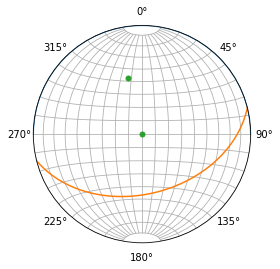

In [12]:
print("%f x + %f y  %f = z" % (C[0], C[1], C[2]))
print("R2 = %f" %R2)
print("std_error = %f" %std_error)
print("std_z = %f" %std_z)
# print("R2_adj = %f" %R2_adj)#ricavo la direzione e l'immersione del piano attraverso l'equazione del piano e i coseni direttori

A=C[0]
B=C[1]
C_=-1
D=C[2]

#calcolo E
E=np.sqrt(A**2 + B**2 + 1)

#calcolo i coseni
cos_a = A/E

cos_b = B/E

cos_cp = C_/E  #gamma_p


cos_c = np.cos((np.pi/2) + np.arccos(C_/E))   #controllare se è corretto 

#calcolo la direzione teta del vettore, il coseni direttori danno la direzione del vettore occorrre aggiungere 90°
teta_primo = np.arctan(cos_a/cos_b)   #espresso in radianti
teta_deg = (teta_primo*180)/np.pi 

#calcolo della direzione della massima pendenza sul piano
#dip_direction = teta_deg 

#calcolo l'immersione dip angolo tra la verticale e il piano
dip_vert = np.arcsin(-1*cos_c)
dip_deg = (dip_vert*180)/np.pi

#calcolo l'immersione dip
dip = dip_deg
#occorre orientare correttamente il dip_direction
#cond_1 = dip_direction = teta_deg
#cond_2 = dip_direction = teta_deg + 180
#cond_3 = dip_direction =  teta_deg + 360
    
#def orientation(cos_a,cos_b):
    
if cos_a > 0 and cos_b > 0:                
    dip_direction = teta_deg
    if cos_cp <0:
        dip_direction =  dip_direction + 180
        
if  cos_a > 0 and cos_b < 0:
    dip_direction = teta_deg + 180
    if cos_cp <0:
        dip_direction =  dip_direction + 180
        
            
if  cos_a < 0 and cos_b < 0:
    dip_direction = teta_deg + 180
    if cos_cp <0:
        dip_direction =  dip_direction - 180
       
    
if  cos_a < 0 and cos_b > 0:
    dip_direction =  teta_deg + 360
    if cos_cp <0:
        dip_direction =  dip_direction - 180
    

    

    
         


#creo l'array per il plotaggio su stereogramma
plot_dip_direction = 0
plot_dip = 0
plot_dip_direction = np.append(plot_dip_direction, dip_direction)
plot_dip = np.append(plot_dip, dip)
print("dip_direction= %f ; dip= %f" % (dip_direction, dip))
print(cos_a, cos_b)
print('##################################################')
print(teta_deg)
output = "teta= %f ; dip= %f" % (dip_direction, dip)
file = open("giacitura_cluster_xx_plane.txt","w")
file.write(output)
file.close()

daframe_cluster_xx = pd.DataFrame.to_csv(df_cluster_2)
file = open("daframe_cluster_xx_plane.csv","w")
file.write(daframe_cluster_xx)
file.close()

#salva i risultati su di un file shape
geometry = [Point(xy) for xy in zip(df_cluster_2.x , df_cluster_2.y)]
df_shape = df_cluster_2.drop(['x', 'y','Ora', 'Data', 'Sec'], axis=1)
crs = {'init': 'epsg:3003'}
gdf = GeoDataFrame( df_shape, crs=crs, geometry=geometry)   #df_shape,
gdf.to_file(driver = 'ESRI Shapefile', filename= "result_xx_plane.shp" )



strike = plot_dip_direction - 90 
dip =  plot_dip
fig = plt.figure()
ax = fig.add_subplot(111, projection='stereonet')
ax.plane(strike, dip)
ax.pole(strike, dip ,markersize=5)
ax.grid()
plt.show()

# sklearn.linear_model.LinearRegression

In [13]:
from sklearn import datasets
from sklearn.model_selection import cross_val_predict
from sklearn import linear_model
import matplotlib.pyplot as plt


A_ = np.c_[data[:,0], data[:,1], np.ones(data.shape[0])]
L = data[:,2]

lr = linear_model.LinearRegression()


fit = lr.fit(A_,L,W)



print(fit.coef_)
print(fit.intercept_)
print(fit.score(A_,L,W))

[-0.27392531  0.91726747  0.        ]
-4112612.1432291954
0.41433111325646343


dip_direction= 163.372698 ; dip= 43.750113
-0.19787340118661922 0.6625997185310506
##################################################
-16.627302166249642


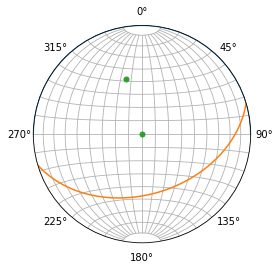

In [14]:


A=fit.coef_[0]
B=fit.coef_[1]
C_=-1
D=fit.intercept_

piano(A,B,C_,D)


# Calcolo la regressione lineare con errori dei coeficenti del piano

In [15]:
# calcolaliamo l'errore dei coeficenti dell'equazione del piano

import statsmodels.api as sm
#https://www.statsmodels.org/stable/regression.html
#ols = sm.OLS(L,A)

wls_model = sm.WLS(L,A_,W)

#reg = sm.RegressionResults(L,A)
#ols_result = ols.fit()
wls_result = wls_model.fit()
#print(ols_result.summary())
print(wls_result.summary())
print(wls_result.conf_int())
x1_err,x2_err,const_err = wls_result.conf_int() # vedi http://www.statsmodels.org/devel/generated/statsmodels.regression.linear_model.RegressionResults.conf_int.html



/home/nbuser/anaconda3_501/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning:

The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.



                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.414
Model:                            WLS   Adj. R-squared:                  0.389
Method:                 Least Squares   F-statistic:                     16.63
Date:                Sat, 26 May 2018   Prob (F-statistic):           3.47e-06
Time:                        19:15:48   Log-Likelihood:                -461.72
No. Observations:                  50   AIC:                             929.4
Df Residuals:                      47   BIC:                             935.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.2739      0.232     -1.181      0.2

In [16]:
A=wls_result.params[0]
B=wls_result.params[1]
C_=-1
D=wls_result.params[2]
print(A,B,C_,D)

-0.2739253117274258 0.9172674718315468 -1 -4112612.14323019


dip_direction= 163.372698 ; dip= 43.750113
-0.19787340118660338 0.6625997185311325
##################################################
-16.62730216624644


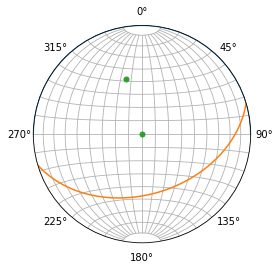

In [17]:
piano(A,B,C_,D)


In [18]:
A=x1_err[0]
B=x2_err[0]
C_=-1
D=wls_result.params[2]

print(A,B,C_,D)

-0.7407126770313053 0.42279168663615874 -1 -4112612.14323019


dip_direction= 119.717310 ; dip= 40.460272
-0.563575758406582 0.32168363365799496
##################################################
-60.28269022705753


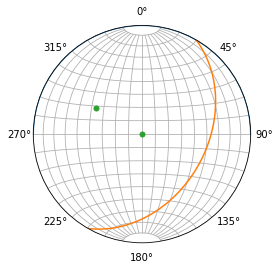

In [19]:
piano(A,B,C_,D)


0.1928620535764537 1.4117432570269348 -1 -1178698.5667160302
dip_direction= 187.779175 ; dip= 54.937852
0.11079242790169655 0.8109965652619128
##################################################
7.779175155533228


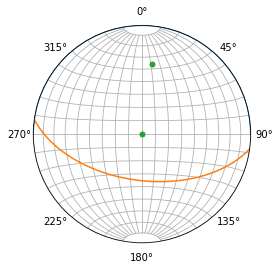

In [20]:
A=x1_err[1]
B=x2_err[1]
C_=-1
D=const_err[1]

print(A,B,C_,D)
piano(A,B,C_,D)

In [21]:
const_err[0]

-7046525.71974435

In [22]:
import plotly.plotly as py
import plotly.graph_objs as go

import numpy as np


z_err_1 = x1_err[1]*X + x2_err[1]*Y + wls_result.params[2]


Z= wls_result.params[0]*X + wls_result.params[1]*Y + wls_result.params[2]
    

trace1 = go.Scatter3d(
    x=data[:,0],
    y=data[:,1],
    z=data[:,2],
    mode='markers',
    marker=dict(size=4, color='red', line=dict(color='black', width=0.5), opacity=0.85)
)

trace2 = go.Surface(z=Z, x=X, y=Y, colorscale='RdBu', opacity=0.6)
trace3 = go.Surface(z=z_err_1, x=X, y=Y, colorscale='Viridis', opacity=0.6)

best_fit_plane = trace3
# Package the trace dictionary into a data object
data_test1 = go.Data([ trace1, trace2,trace3])

# Dictionary of style options for all axes
axis = dict(
    showbackground=True, # show axis background
    backgroundcolor="rgb(204, 204, 204)", # set background color to grey
    gridcolor="rgb(255, 255, 255)",       # set grid line color
    zerolinecolor="rgb(255, 255, 255)",   # set zero grid line color
)

# Make a layout object
layout = go.Layout(
    title='1st-order (linear) plane', # set plot title
    scene=go.Scene(  # axes are part of a 'scene' in 3d plots
        xaxis=go.XAxis(axis), # set x-axis style
        yaxis=go.YAxis(axis), # set y-axis style
        zaxis=go.ZAxis(axis)),  # set z-axis style
)

# Make a figure object
fig = go.Figure(data=data_test1, layout=layout)

# Send to Plotly and show in notebook
#py.iplot(fig, filename='test1') # decommentare per plottare su server online
plot(fig)
iplot(fig)

# Calcolo delle incertezze

In [23]:
print(z_err_1)


[[3140290.37278158 3140387.90952118 3140485.44626078 3140582.98300038
  3140680.51973998 3140778.05647958 3140875.59321918 3140973.12995879
  3141070.66669839 3141168.20343799 3141265.74017759 3141363.27691719
  3141460.81365679 3141558.35039639 3141655.88713599 3141753.42387559
  3141850.96061519 3141948.49735479 3142046.03409439 3142143.57083399]
 [3140810.6983825  3140908.2351221  3141005.7718617  3141103.3086013
  3141200.84534091 3141298.38208051 3141395.91882011 3141493.45555971
  3141590.99229931 3141688.52903891 3141786.06577851 3141883.60251811
  3141981.13925771 3142078.67599731 3142176.21273691 3142273.74947651
  3142371.28621611 3142468.82295571 3142566.35969531 3142663.89643491]
 [3141331.02398342 3141428.56072302 3141526.09746263 3141623.63420223
  3141721.17094183 3141818.70768143 3141916.24442103 3142013.78116063
  3142111.31790023 3142208.85463983 3142306.39137943 3142403.92811903
  3142501.46485863 3142599.00159823 3142696.53833783 3142794.07507743
  3142891.61181703 

In [24]:
#########################################fine###########